In [2]:
from utilities import *
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [3]:
X_train, y_train, X_test, y_test = load_data()

In [4]:
print(X_train.shape)
print(y_train.shape)   
print(np.unique(y_train, return_counts=True))

(1000, 64, 64)
(1000, 1)
(array([0., 1.]), array([500, 500]))


In [5]:
print(X_test.shape)
print(y_test.shape)
print(np.unique(y_test, return_counts=True))

(200, 64, 64)
(200, 1)
(array([0., 1.]), array([100, 100]))


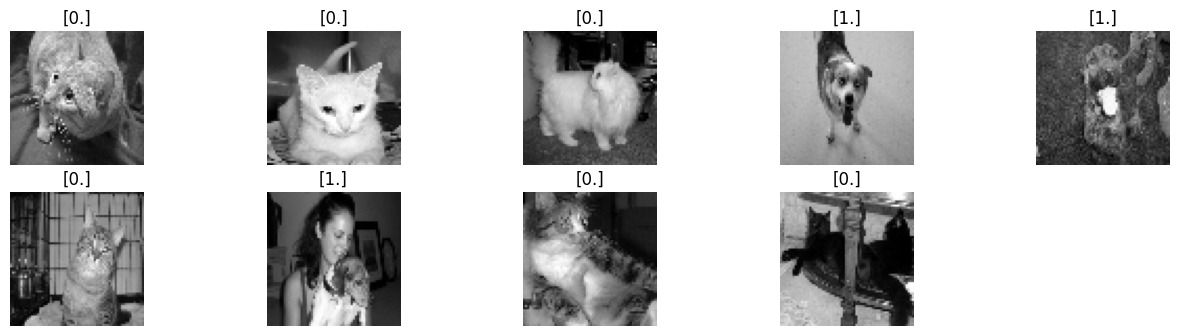

In [6]:
plt.figure(figsize=(16,8))
for i in range(1,10):
    plt.subplot(4,5,i)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')

plt.show()

In [7]:
# TO DO 
# 1. Normaliser le train_set et le test_set (0-255 -> 0-1)
# 2. flatten() les variables du train_set et du test_set (64x64 -> 4096)
# 3. Entrainer le modele sur le train_set (tracer la courbe d'apprentissage, trouver les bons hyper-params)
# (si vous rencontrez un probleme avec le log_loss, utiliser la fonction de sklearn a la place !)
# 4. Évaluer le modele sur le test_set (tracer également la courbe de Loss pour le test_set)
# 5. Partager vos conclusions dans les commentaires !

In [8]:
# Normalisation et reshape
X_train_reshaped = X_train.reshape(X_train.shape[0], -1) / X_train.max() # X - Xmin / (Xmax - Xmin)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1) / X_train.max() # X - Xmin / (Xmax - Xmin)

In [9]:
X_train_reshaped.shape

(1000, 4096)

In [10]:
class entrainement:
    def __init__(self, X):
        self.W = np.random.randn(X.shape[1],1)
        self.b = np.random.randn(1)
        
    def logit(self, X): # z = W*X + b
        return np.dot(X, self.W) + self.b
    
    def sigmoid_activation(self, z): # A = 1 / (1 + e^(-z))
        return 1 / (1 + np.exp(-z)) 
    
    def loss(self, y, A):  # L = -1/m * sum(y*log(A) + (1-y)*log(1-A))
        epsilon = 1e-5
        return -np.mean(y * np.log(A+epsilon) + (1-y) * np.log(1-A+epsilon)) 
    
    def gradient(self, A, X, y):
        m = len(y)
        dW = 1/m * np.dot(X.T, (A-y))
        db = 1/m * np.sum(A-y)
        return (dW, db)

    def update(self, dW, db, learning_rate):
        self.W -= learning_rate * dW
        self.b -= learning_rate * db
        return (self.W, self.b)
    
    def predict(self, X, W, b):
        A = self.sigmoid_activation(self.logit(X))
        return A>=0.5

    
    def train(self, X, y, learning_rate=0.01, n_iter=10000):
        losses = []
        acc =  []
        for i in tqdm(range(n_iter)):
            z = self.logit(X)
            A = self.sigmoid_activation(z)
            loss = self.loss(y, A)
            dW, db = self.gradient(A, X, y)
            self.update(dW, db, learning_rate)
            if i % 10 ==0:
                losses.append(loss)
                y_pred = self.predict(X, self.W, self.b)
                acc.append(accuracy_score(y, y_pred))
        return losses, acc


In [11]:
model = entrainement(X_train_reshaped)
losses, acc = model.train(X_train_reshaped, y_train)



100%|██████████| 10000/10000 [02:35<00:00, 64.26it/s]


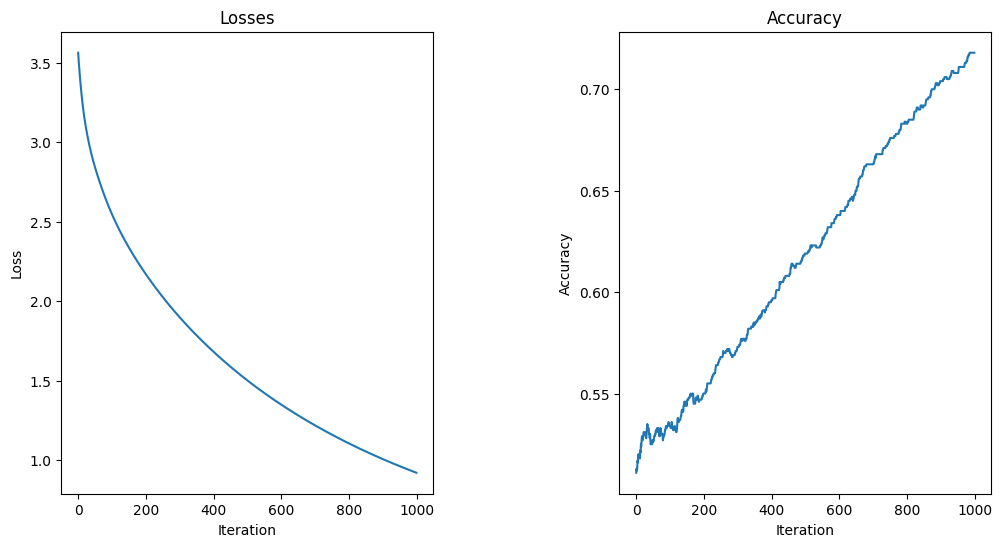

In [12]:
plt.figure(figsize=(12, 6))  

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(acc)
plt.title('Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

plt.subplots_adjust(wspace=0.5)  


With a deep neural network

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss


In [20]:
def initialisation(dimensions):
    
    parameters = {}
    C = len(dimensions)
    
    for c in range(1, C):
        parameters['W' + str(c)] = np.random.randn(dimensions[c], dimensions[c-1])
        parameters['b' + str(c)] = np.zeros((dimensions[c], 1))
     
    return parameters

In [21]:
def forward_propagation(X, parameters):
    
    activations = {'A0': X}
    C = len(parameters) // 2
    
    for c in range(1, C+1):
        Z = parameters['W' + str(c)].dot(activations['A' + str(c-1)]) + parameters['b' + str(c)]
        activations['A' + str(c)] = 1 / (1 + np.exp(-Z))
        
    return activations

In [22]:
def back_propagation(y, activations, parameters):
        
        m = y.shape[1]
        C = len(parameters) // 2

        dZ = activations['A' + str(C)] - y
        gradients = {}

        for c in reversed(range(1,C+1)):
            gradients['dW' + str(c)] = 1/m * dZ.dot(activations['A' + str(c-1)].T)
            gradients['db' + str(c)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
            if c>1:
                dZ = np.dot(parameters['W' + str(c)].T, dZ) * activations['A' + str(c-1)] * (1 - activations['A' + str(c-1)])

        

In [23]:
def update(gradients, parameters, learning_rate):
    
    C = len(parameters) // 2
    
    for c in range(1, C+1):
        parameters['W' + str(c)] -= learning_rate * gradients['dW' + str(c)]
        parameters['b' + str(c)] -= learning_rate * gradients['db' + str(c)]
        
    return parameters

In [24]:
def predict(X, parametres):
  activations = forward_propagation(X, parametres)
  C = len(parametres) // 2
  Af = activations['A' + str(C)]
  return Af >= 0.5

In [26]:

def deep_neural_network(X, y, hidden_layers = (16, 16, 16), learning_rate = 0.001, n_iter = 3000):
    
    # initialisation parametres
    dimensions = list(hidden_layers)
    dimensions.insert(0, X.shape[0])
    dimensions.append(y.shape[0])
    np.random.seed(1)
    parametres = initialisation(dimensions)

    # tableau numpy contenant les futures accuracy et log_loss
    training_history = np.zeros((int(n_iter), 2))

    C = len(parametres) // 2

    for i in tqdm(range(n_iter)):

        activations = forward_propagation(X, parametres)
        gradients = back_propagation(y, parametres, activations)
        parametres = update(gradients, parametres, learning_rate)
        Af = activations['A' + str(C)]

        # calcul du log_loss et de l'accuracy
        training_history[i, 0] = (log_loss(y.flatten(), Af.flatten()))
        y_pred = predict(X, parametres)
        training_history[i, 1] = (accuracy_score(y.flatten(), y_pred.flatten()))

    # Plot courbe d'apprentissage
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(training_history[:, 0], label='train loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(training_history[:, 1], label='train acc')
    plt.legend()
    plt.show()

    

    return training_history